In [1]:
import tensorflow as tf

### Configuration
create_dataset = True

def in_google_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Get the platform
if in_google_colab():
    print("Running in Google Colab")
    !git clone https://github.com/naderinho/anesthesia_anomaly_detection
    !pip install vitaldb
    directory = 'anesthesia_anomaly_detection/data/'
    create_dataset = False
else:
    print("Running locally")
    directory = 'data/'

### Datasetpath
datasetpath = 'dataset01/'
vitaldbpath = 'vitaldb_tiva/'

import numpy as np
import pandas as pd
import vitaldb as vf
import matplotlib.pyplot as plt

Running in Google Colab
Cloning into 'anesthesia_anomaly_detection'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 45 (delta 3), reused 45 (delta 3), pack-reused 0
Receiving objects: 100% (45/45), 17.00 MiB | 16.69 MiB/s, done.
Resolving deltas: 100% (3/3), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 6.0 MB/s eta 0:00:00


In [2]:
from scipy import ndimage

def outlierfilter(data: pd.DataFrame,threshhold: float, iterations: int, min: float, max: float):
    """
    A filter function, which calculates the gradient of a given Pandas DataFram Timeseries
    and performs a binary dilation on datapoints which exceed a certain treshhold, to detect
    and remove unwanted outliers in the dataset. Additionally all values exceeding a given
    min/max value are replaced with np.nan and linearly interpolated with the Pandas interpolate
    method.

    Args:
        data (pd.DataFrame): Timeseries Data
        threshhold (float): Gradient thresshold
        iterations (int): number of iterations of the binary dilation
        min (float): maximum expected value
        max (float): minimum expected value

    Returns:
        pd.DataFrame: _description_
    """
    gradient = np.diff(data,n=1, axis=0, append=0)
    gradientfilter = ndimage.binary_dilation(np.abs(gradient) > threshhold, iterations=iterations)

    # Apply Filter
    data[gradientfilter] = np.nan

    data[data <= min] = np.nan
    data[data > max] = np.nan

    data = data.interpolate(method = 'linear')
    data = data.bfill()
    return data

In [3]:
from os import listdir
from sklearn.model_selection import train_test_split

class DatasetImport():
    def __init__(self, directory: str, dataset: str, vitalpath: str, interval: int = 10):
        self.directory = directory
        self.datasetpath = directory + dataset
        self.vitalpath = directory + vitalpath

        self.interval = interval

        self.train_dataset = None
        self.test_dataset = None

        self.index = pd.read_csv(self.datasetpath +'dataset.csv', index_col=0).index.to_numpy()

    def save(self, filename: str):
        np.savez_compressed(self.datasetpath+filename,
                            train = self.train_dataset,
                            test = self.test_dataset,
                            timesteps = self.timesteps,
                            )

    def load(self, filename: str):
        data = np.load(self.datasetpath+filename)
        self.train_dataset = data['train']
        self.test_dataset = data['test']
        try:
            self.timesteps = data['timesteps']
        except:
            self.timesteps = []

    def split(self,data):
       return train_test_split(data, test_size=0.2, random_state=42)

    def generateDataset(self, normalize: bool = True):

        dataset, self.timesteps = self.generate(self.index, normalize)

        self.train_dataset, self.test_dataset = self.split(dataset)
        print('Dataset succesfully generated                 ')

    def generate(self, dataset_index: list, normalize: bool):
        batch_list = []
        timesteps = []

        for i, caseid in enumerate(dataset_index):
            filepath = self.vitalpath+str(caseid).zfill(4)+'.vital'
            data, importName = self.importFunction(filepath)
            timesteps.append(data.shape[0])
            batch_list.append(data)
            print(importName + " Fortschritt: %.1f" % (100 * (i+1) / len(dataset_index)),' % ', end='\r')

        ### Pad the dataset
        data = tf.keras.preprocessing.sequence.pad_sequences(batch_list, padding='post', dtype='float32', value=0.0)

        ### Normalize the data
        if normalize:
            data = self.normalize(data)

        return data, np.array(timesteps)

    def importFunction(self, filepath: str):
        return None, None

    def normalize(self, dataset: np.array, padded: bool = True):

        if padded:
            dataset[dataset == 0.0] = np.nan

        mean = np.nanmean(dataset)
        std = np.nanstd(dataset)

        dataset = (dataset - mean) / std
        np.nan_to_num(dataset, copy=False, nan=0.0)
        return dataset

class infoImport(DatasetImport):
    def __init__(self, directory: str, dataset: str, vitalpath: str):
        super().__init__(directory,dataset,vitalpath)

        self.columns = ['age','sex','height','weight','bmi']

    def generate(self, dataset_index: list, normalize: bool = True):

        data = pd.read_csv(self.directory+'info_vitaldb/cases.csv', index_col=0)
        data = data[self.columns].loc[dataset_index].to_numpy()
        data[:, 1] = np.where(data[:, 1] == 'F', 0, 1)
        data = data.astype(float)

        if normalize:
            data = self.normalize(data, padded=False)

        return data, None

class VitalImport(DatasetImport):
    def __init__(self, directory: str, dataset: str, vitalpath: str):
        super().__init__(directory,dataset,vitalpath)

        self.tracks = []
        self.filter = [0,0,0]
        self.name = 'Vital'

    def importFunction(self, filepath: str):

        vitaldata = vf.VitalFile(ipath = filepath, track_names = self.tracks)

        data = vitaldata.to_pandas(track_names=self.tracks,interval=self.interval)

        data = outlierfilter(data, threshhold = self.filter[0] , iterations = 2, min = self.filter[1], max = self.filter[2])

        return data, self.name

class BISImport(DatasetImport):
    def __init__(self, directory: str, dataset: str, vitalpath: str):
        super().__init__(directory,dataset,vitalpath)

    def importFunction(self, filepath: str):
        vitaldata = vf.VitalFile(ipath = filepath, track_names = ['BIS/BIS'])

        data = vitaldata.to_pandas(track_names=['BIS/BIS'],interval=self.interval)

        data = outlierfilter(data, threshhold = 20 , iterations = 2, min = 0, max = 100)

        data = (100 - data) / 100 + 0.0001 # add a small value to avoid false padding
        return data, 'BIS'

class BPImport(DatasetImport):
    def __init__(self, directory: str, dataset: str, vitalpath: str):
        super().__init__(directory,dataset,vitalpath)

    def importFunction(self, filepath: str):
        pressureWave = vf.VitalFile(filepath).to_numpy(['SNUADC/ART'], 1/500)

        samples = self.interval * 500

        # Remove values which derivative is too large
        gradient = np.diff(pressureWave,n=1, axis=0, append=0)
        gradientfilter1 = ndimage.binary_dilation(np.abs(gradient) > 4,iterations=30)
        gradientfilter2 = ndimage.binary_dilation(np.abs(gradient) > 7,iterations=1000)
        pressureWave[gradientfilter1] = np.nan
        pressureWave[gradientfilter2] = np.nan

        # Remove the negative values and values above 250
        pressureWave[pressureWave <= 20] = np.nan
        pressureWave[pressureWave > 250] = np.nan

        pressureWave = self.imputer1.fit_transform(pressureWave)

        ### Reshape the pressureWave to 1000 samples (2 seconds) per row
        #if (pressureWave.shape[0] % samples) != 0 :
        #    steps2fill = samples - (pressureWave.shape[0] % samples)
        #    pressureWave = np.pad(array=pressureWave, pad_width=((0,steps2fill),(0,0)), mode='constant', constant_values=np.nan)
        length = pressureWave.shape[0] - (pressureWave.shape[0] % samples)
        pressureWave = pressureWave[0:length]
        return pressureWave.reshape(-1,samples), 'Blood Pressure'

In [4]:
###### Create Dataset
if create_dataset:
    bis = BISImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    bis.generateDataset(normalize=False)
    bis.save('00_bis.npz')

    info = infoImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    info.generateDataset()
    info.save('01_info.npz')

    bloodpressure = VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    bloodpressure.name = 'bloodpressure'
    bloodpressure.tracks = ['Solar8000/ART_DBP', 'Solar8000/ART_MBP', 'Solar8000/ART_SBP']
    bloodpressure.filter = [20, 20, 250]
    bloodpressure.generateDataset()
    bloodpressure.save('02_bloodpressure.npz')

    etCO2 = VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    etCO2.name = 'End Tidal CO2'
    etCO2.tracks = ['Primus/ETCO2']
    etCO2.filter = [5, 15, 50]
    etCO2.generateDataset()
    etCO2.save('02_etCO2.npz')

    spO2 = VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    spO2.name = 'SpO2'
    spO2.tracks = ['Solar8000/PLETH_SPO2']
    spO2.filter = [3, 80, 100]
    spO2.generateDataset()
    spO2.save('02_spO2.npz')

    hr = VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    hr.name = 'Heart Rate'
    hr.tracks = ['Solar8000/HR']
    hr.filter = [20, 40, 180]
    hr.generateDataset()
    hr.save('02_hr.npz')



In [5]:
### Load the datasets
bis = BISImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
bis.load('00_bis.npz')

info = infoImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
info.load('01_info.npz')

bloodpressure = VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
bloodpressure.load('02_bloodpressure.npz')

etCO2 = VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
etCO2.load('02_etCO2.npz')

spO2 = VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
spO2.load('02_spO2.npz')

hr = VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
hr.load('02_hr.npz')

In [6]:
########################################## COMBINED MODEL ##########################################
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, ReLU, Dropout, Concatenate, Masking, Conv1D, MaxPooling1D, BatchNormalization, RepeatVector

### Combine the vital data
vital_train = np.concatenate([bloodpressure.train_dataset, etCO2.train_dataset, spO2.train_dataset, hr.train_dataset], axis=2)
vital_test = np.concatenate([bloodpressure.test_dataset, etCO2.test_dataset, spO2.test_dataset, hr.test_dataset], axis=2)

### LSTM layers for the vital data
input_vital = Input(shape=(None, vital_train.shape[2]))
vital_layer = Masking(mask_value=999.0)(input_vital)
vital_layer = Dense(units=32, activation='sigmoid')(vital_layer)
vital_layer = BatchNormalization()(vital_layer)
vital_layer = Dense(units=256, activation='sigmoid')(vital_layer)
vital_layer = BatchNormalization()(vital_layer)
vital_layer = Dense(units=128, activation='sigmoid')(vital_layer)
vital_layer = BatchNormalization()(vital_layer)
vital_layer = LSTM(units=128, return_sequences=True)(vital_layer)
vital_layer = BatchNormalization()(vital_layer)
vital_layer = LSTM(units=128, return_sequences=True)(vital_layer)
vital_layer = BatchNormalization()(vital_layer)

### INFO layers
input_info = Input(shape=(info.train_dataset.shape[1],))
info_layer = Dense(units=32, activation='relu')(input_info)
info_layer = BatchNormalization()(info_layer)
info_layer = Dense(units=64, activation='relu')(input_info)
info_layer = BatchNormalization()(info_layer)
info_layer = Dense(units=32, activation='relu')(input_info)
info_layer = BatchNormalization()(info_layer)

info_layer = RepeatVector(vital_train.shape[1])(info_layer)

## Concatenate the LSTM output with the info layer
comb_layer = Concatenate()([vital_layer, info_layer])
comb_layer = Dense(units=256, activation='relu')(comb_layer)
comb_layer = BatchNormalization()(comb_layer)
comb_layer = LSTM(units=256, return_sequences=True)(comb_layer)
comb_layer = BatchNormalization()(comb_layer)
comb_layer = LSTM(units=128, return_sequences=True)(comb_layer)
comb_layer = BatchNormalization()(comb_layer)
comb_layer = Dense(units=128, activation='relu')(comb_layer)
comb_layer = BatchNormalization()(comb_layer)
comb_layer = Dense(units=32, activation='relu')(comb_layer)
comb_layer = BatchNormalization()(comb_layer)


output = Dense(units=1)(comb_layer)
output = ReLU(max_value=1.0)(output)

# Define the model
model = Model(inputs=[input_vital, input_info], outputs=output)

# Compile the model
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer, loss='mse')
model.summary()
y = pd.DataFrame(bis.train_dataset[:,:,0].T).rolling(min_periods=1,window=60, center=True).mean().to_numpy().T[:,:,np.newaxis]
#y = bis.train_dataset
# Train the model
history = model.fit([vital_train, info.train_dataset], y, epochs=30, batch_size=4)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 6)]            0         []                            
                                                                                                  
 masking (Masking)           (None, None, 6)              0         ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (None, None, 32)             224       ['masking[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, 32)             128       ['dense[0][0]']               
 Normalization)                                                                               

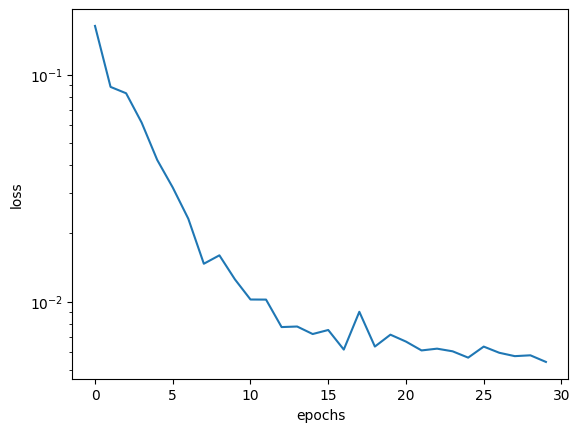

In [7]:
########################################## TRAINING SUMMARY ##########################################

# Evaluate the mod
plt.figure()
plt.plot(model.history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale("log")
plt.show()

1/1 [==============================] - 5s 5s/step


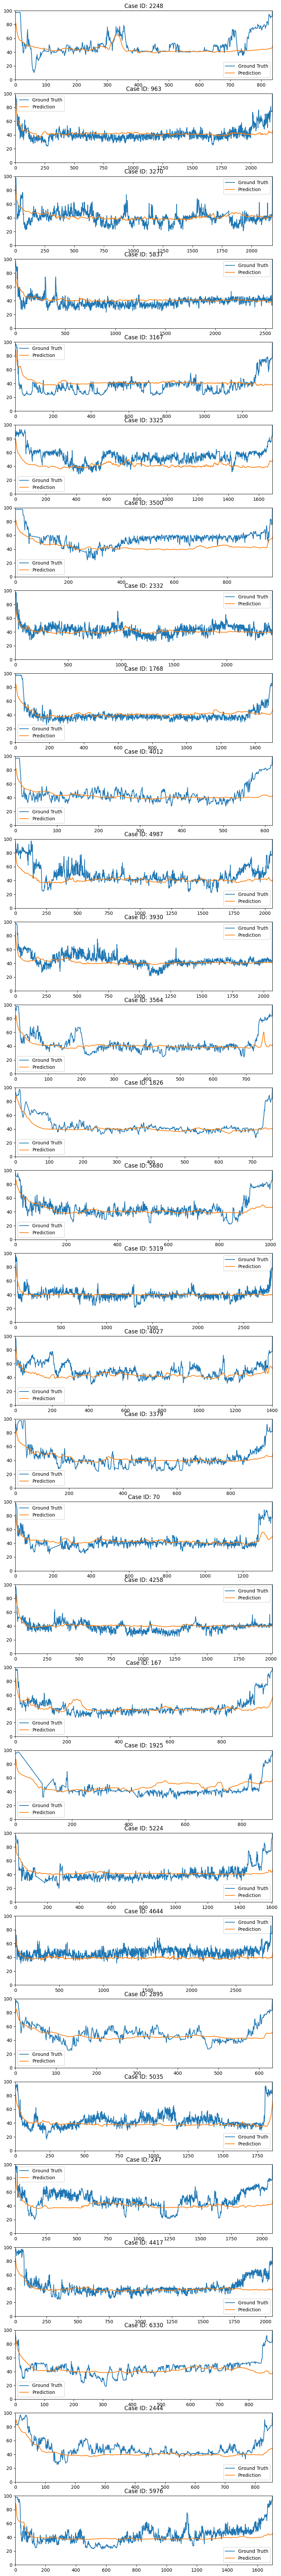

In [8]:
########################################## TESTING ##########################################
import matplotlib.pyplot as plt

# Prediction
y_test = []
y_pred_test = []

fig, axs = plt.subplots(bis.test_dataset.shape[0], 1, figsize=(10, 100))

y_pred =  model.predict([vital_test, info.test_dataset])
y_pred = - (y_pred * 100) + 100

ground_truth = - (bis.test_dataset * 100) + 100

test_index = bis.split(np.array(bis.index))[1]
timesteps = bis.split(bis.timesteps)[1]

for j, filename in enumerate(test_index):
    axs[j].plot(ground_truth[j,:,:], label='Ground Truth')
    axs[j].plot(y_pred[j,:,:], label='Prediction')
    axs[j].legend()
    axs[j].set_title('Case ID: ' + str(filename))
    axs[j].axis([0,timesteps[j],0,100])